Bienvenido a la práctica de Traveling Salesman Problem de Hugo Romero, Irene Fernández y Maribel Medrano.
A continuación se hará un tour por el proceso de realización de la práctica, en algunos pasos no se corresponderá la ejecución al 100% con lo realizado por nosotros, dado que no queremos que el tiempo de ejecución de este lab se dispare, pero servirá para narrar y entender el proceso.

Algunas herramientas que se utilizarán en la clase TSP

In [8]:
import math
#Función read_file implementada por Hugo Romero
#LEE UN FICHERO DE TEXTO PLANO Y LO DEVUELVE COMO STRING
def read_file(file):
    with open(file, 'r') as reader:
        content = reader.read().splitlines()
        lines = [x.lstrip() for x in content if x != ""]
        return lines

#Función angle(tuple, tuple) implementada por Hugo Romero
#CALCULA EL ANGULO (GONIOMÉTRICO) ENTRE EL EJE X Y EL VECTOR QUE FORMAN LOS PUNTOS DE ENTRADA
def angle(point, center):
    vector_1 = [point[0]-center[0], point[1]-center[1]]
    angle = math.atan2(vector_1[1], vector_1[0]) * 180 / math.pi
    return round(angle,4)

def save_string(filename, output):
    with open("./TSP_generados/" + filename, 'w') as file:
        file.write(output)
    return

En primer lugar realizamos la creación de la clase TSP:

In [36]:
from matplotlib import pyplot as plt
import random
import math
import time
import numpy as np


class TSP:
   #Función __init__(TSP) implementada por Hugo Romero
   #CONSTRUCTOR DE LA CLASE TSP
    def __init__(self):
        self.nombre = ''
        self.filename = ''
        self.dimension = 0
        self.problema = {}
        self.solution = []
        self.figures = 0
        self.graph = []
    
    #Función generate_graph(self) implementada por Hugo Romero
    #Calcula y almacena en graph las aristas (carreteras) entre ciudades (todas, dado que es un nodo completo)
    def generate_graph(self):
        self.graph = np.array([[self.distance(city1, city2) for city2 in list(self.problema.keys())] for city1 in
                      list(self.problema.keys())])
    
    #Función obtener_desde_archivo_tsp(self, string) implementada por Hugo Romero
    # Genera un escenario a partir de un archivo .tsp, debe estar en la carpeta TSP_interesantes
    # Se espera que sea un archivo tsp de vertices (coordenadas), no de aristas.
    def obtener_desde_archivo_tsp(self, tsp_name):
        tsp_file = tsp_name
        lines = read_file(tsp_file)
        self.nombre = [line.replace('NAME: ', '') for line in lines if 'NAME: ' in line][0].strip()
        self.filename = tsp_name
        self.dimension = int([line.partition('DIMENSION:')[2] for line in lines if 'DIMENSION: ' in line][0])
        index_for_search = [index for index, line in enumerate(lines) if 'NODE_COORD_SECTION' in line][0] + 1
        cities_data = lines[index_for_search:index_for_search + self.dimension]
        self.problema = {}
        for city in cities_data:
            idx, x, y = map(float, city.split(' '))
            self.problema[int(idx)] = (x, y)

        self.generate_graph()
        self.solution = list(self.problema.keys())
        print(f'Fichero {tsp_name} parseado con exito')
    
    #Función aplicar_mejor_solucion_desde_archivo(self) implementada por Hugo Romero
    #Si el escenario proviene de un fichero tsp, lee la solucion del archivo de
    #solucion correspondiente
    def aplicar_mejor_solucion_desde_archivo(self):
        # if '.tsp' not in self.filename:
        #     print(f'El escenario {self.nombre} no fue generado apartir de un archivo .tsp')
        #     return
        solution_file =  self.filename.replace('.tsp', '') + ".opt.tour"
        
        lines = read_file(solution_file)
        index_for_search = [index for index, line in enumerate(lines) if 'TOUR_SECTION' in line][0] + 1

        next_line = lines[index_for_search]
        # if else porque a veces la solucion a parece en una sola linea y a veces en varias
        if sum([str(city) in next_line for city in self.solution]) == self.dimension:
            self.solution = list(map(int, next_line.split(' ')))
        else:
            self.solution = list(map(int, lines[index_for_search:index_for_search + self.dimension]))
            print(self.solution)
        self.ordenar_solucion()
        print(f'Solucion desde archivo: {self.compute_dist()} m')
    
    #Función obtener_random(self, int) implementada por Hugo Romero
    # Genera un escenario aleatorio de {dimension} CIUDADES
    def obtener_random(self, dimension):
        self.nombre = f'Aleatorio{int(time.time())}_{dimension}.tsp'
        self.dimension = dimension
        self.problema = {}
        for i in range(1, dimension + 1):
            self.problema[i] = round(random.random() * 50, 2), round(random.random() * 50, 2)
        self.generate_graph()
        self.solution = list(self.problema.keys())
    
    #Función shuffle(self) implementada por Hugo Romero
    # PARA DESORDENAR LAS CIUDADES DE LA SOLUCION
    # Puede ser util para evaluar varias soluciones sobre un mismo escenario
    # pero que una soluciones no influyan sobre las otras
    def shuffle(self):
        aux = self.solution[1:]
        random.shuffle(aux)
        self.solution[1:] = aux
    
    #Función greedy_solve(self) -> float implementada por Hugo Romero
    #Solucion con algoritmo greedy, la siguiente ciudad es la mas cercana no visitada
    #Devuelve el tiempo de ejecucion del algoritmo
    def greedy_solve(self):
        start = time.time()
        to_put = set(self.solution)
        new_solution = [self.solution[0]]
        to_put.remove(self.solution[0])
        while (len(to_put) > 1):
            current = new_solution[-1]
            current_distance = float('inf')
            current_best = -1
            for city in to_put:
                dist = self.graph[current-1][city-1]
                if dist < current_distance:
                    current_distance = dist
                    current_best = city
            new_solution.append(current_best)
            to_put.remove(current_best)
        new_solution.append(to_put.pop())
        self.solution = new_solution
        end = time.time()
        self.ordenar_solucion()
        print(f'Solución greedy generada: {self.compute_dist()}m')
        return end - start

    #Función r_solve(self) -> float implementada por Hugo Romero
    #Solucion con un algoritmo que se me ha ocurrido que podría
    #funcionar bien como punto de partida, funciona muy bien 
    #combinada con el 2-opt
    def r_solve(self):
        start = time.time()
        x = [coord[0] for coord in self.problema.values()]
        y = [coord[1] for coord in self.problema.values()]

        center = [np.mean(x), np.mean(y)]
        self.solution.sort(key=lambda point: angle(self.problema[point], center))
        end = time.time()
        self.ordenar_solucion()
        print(f'Solucion r: {self.compute_dist()} m')
        return end - start
    #Función opt2(self) -> float implementada por Hugo Romero
    #La funcion adapta el pseudocodigo de la pagina
    #de wikipedia del 2-opt
    def opt2(self):
        start = time.time()
        improved = True
        while improved:
            improved = False
            best_distance = self.compute_dist()
            for i in range(1, self.dimension - 2):
                for j in range(i + 2, self.dimension):
                    new_route = self.solution.copy()
                    new_route[i:j] = self.solution[j - 1:i - 1:-1]  # operador 2opt
                    new_distance = sum(
                        [self.distance(new_route[index], new_route[(index + 1) % len(new_route)]) for index in
                         range(len(new_route))])

                    if new_distance < best_distance:
                        self.solution = new_route
                        best_distance = new_distance
                        improved = True
                    if improved:
                        break
                if improved:
                    break
        end = time.time()
        self.ordenar_solucion()
        print(f'Solucion 2-opt: {self.compute_dist()} m')
        return end - start

    def backtracking_solve(self):
        """
        Método realizada por:
            - Hugo Romero
            - - Grupo 10: Ramsés Contreras, Alejandro de la Vega, Ricardo Grande
        Calls backtracking method and stores solution's path and minimum weight. Calls for optimized
        backtracking are commented.
        :return: backtracking execution time
        """
        answer = []
        paths = []
        graph = self.graph.copy()

        # USED IN DFBnB: Stores best solution found
        #temp_sol = [float("inf")]

        # Boolean array to check if a node
        # has been visited or not
        v = [False for i in range(self.dimension)]

        # Mark 0th node as visited
        v[0] = True

        # Find the minimum weight Hamiltonian Cycle
        start = time.time()
        self.tsp_backtracking(graph, v, 0, self.dimension, 1, 0, answer, "1", paths)
        # Splits solution by separator and converts each element to int to be stored as a list of ints
        self.solution = [int(x) for x in paths[answer.index(min(answer))].split("->")]
        end = time.time()
        print(min(answer))
        print(self.solution)

        # USED IN DFBnB: Finds the minimum weight Hamiltonian Cycle using DFBnB
        # start = time.time()
        # self.tsp_backtracking_dfbb(graph, v, 0, self.dimension, 1, 0, answer, "1", paths, temp_sol)
        # self.solution = [int(x) for x in paths[answer.index(min(answer))].split("->")]
        # end = time.time()
        # print(min(answer))

        self.ordenar_solucion()
        print(f'Solucion backtracking: {self.compute_dist()} m')
        return end - start

    def tsp_backtracking(self, graph, v, currPos, n, count, cost, answer, path, all_paths):
        """
        Adaptación realizada por:
            - Hugo Romero
            - Grupo 10: Ramsés Contreras, Alejandro de la Vega, Ricardo Grande
        sobre el código de Mohit Kumar en geeksforgeeks.org
        :param graph: matriz representando el grafo del problema
        :param v: vector booleano de nodos, true si han sido visitados, false si no.
        :param currPos: nodo actual
        :param n: número total de nodos
        :param count: número de nodos visitados
        :param cost: coste acumulado
        :param answer: lista con el coste de todas las soluciones encontradas
        :param path: recorrido local de la rama
        :param all_paths: lista con los recorridos de todas las soluciones encontradas
        :return:
        """
        if count == n and graph[currPos][0]:
            answer.append(cost + graph[currPos][0])
            # Append local path to all_paths (stores all solutions' paths)
            all_paths.append(path)
            return
        # BACKTRACKING STEP
        # Loop to traverse the adjacency list
        # of currPos node and increasing the count
        # by 1 and cost by graph[currPos][i] value
        for i in range(self.dimension):
            if v[i] is False and graph[currPos][i]:
                # Mark as visited
                v[i] = True
                self.tsp_backtracking(graph, v, i, n, count + 1, cost + graph[currPos][i],
                                      answer, path + "->" + str(i + 1), all_paths)

                # Mark ith node as unvisited
                v[i] = False

    def tsp_backtracking_dfbnb(self, graph, v, currPos, n, count, cost, answer, path, all_paths, best_sol):
        """
        Adaptación realizada por:
            - Grupo 10: Ramsés Contreras, Alejandro de la Vega, Ricardo Grande
        sobre el código de Mohit Kumar en geeksforgeeks.org para incluir la mejora de poda.
        :param graph: matriz representando el grafo del problema
        :param v: vector booleano de nodos, true si han sido visitados, false si no.
        :param currPos: nodo actual
        :param n: número total de nodos
        :param count: número de nodos visitados
        :param cost: coste acumulado
        :param answer: lista con el coste de todas las soluciones encontradas
        :param path: recorrido local de la rama
        :param all_paths: lista con los recorridos de todas las soluciones encontradas
        :param best_sol: almacena la mejor solución encontrada hasta el momento
        :return:
        """
        if count == n and graph[currPos][0]:
            answer.append(cost + graph[currPos][0])
            # Append local path to all_paths (stores all solutions' paths)
            all_paths.append(path)
            # Updates best solution found
            best_sol[0] = (cost + graph[currPos][0])
            return
        # BACKTRACKING STEP
        # Loop to traverse the adjacency list
        # of currPos node and increasing the count
        # by 1 and cost by graph[currPos][i] value
        for i in range(self.dimension):
            if v[i] is False and graph[currPos][i]:
                # Expand only if current branch has lower weight than best solution found so far
                if cost + graph[currPos][i] < best_sol[0]:
                    # Mark as visited
                    v[i] = True
                    self.tsp_backtracking_dfbnb(graph, v, i, n, count + 1, cost + graph[currPos][i],
                                                answer, path + "->" + str(i + 1), all_paths, best_sol)

                    # Mark ith node as unvisited
                    v[i] = False


    #Función compute_dist(self) -> float implementada por Hugo Romero
    #Calcula la distancia actual de la ruta solucion
    def compute_dist(self):
        total_dist = 0
        for index in range(len(self.solution)):
            total_dist += self.distance(self.solution[index], self.solution[(index + 1) % len(self.solution)])
        return total_dist
    
    #Función distance(self, int, int) -> float implementada por Hugo Romero
    # Devuelve la distancia entre dos ciudades
    def distance(self, city1, city2):
        return math.sqrt((self.problema[city1][0] - self.problema[city2][0]) ** 2 + (
                self.problema[city1][1] - self.problema[city2][1]) ** 2)
    
    #Función ordenar_solucion(self) implementada por Hugo Romero
    # Desplaza (shift) la solucion para que la ruta comience por la primera ciudad
    def ordenar_solucion(self):
        while (self.solution[0] != list(self.problema.keys())[0]):
            self.solution.insert(0, self.solution.pop(-1))
    
    
    
    #Función draw(self) implementada por Hugo Romero
    # Dibuja el problema
    def draw(self):
        x = [coord[0] for coord in self.problema.values()]
        y = [coord[1] for coord in self.problema.values()]
        names = list(self.problema.keys())

        width = 9.6
        height = 7.2
        bool_dim = self.dimension > 20
        figsize = [width + (width * bool_dim), height + (height * bool_dim)]
        plt.figure(self.figures, figsize=figsize)

        self.figures += 1
        plt.scatter(x, y, s=15, marker='x', c='black')
        for txt, x_coord, y_coord in zip(names, x, y):
            plt.annotate(txt, (x_coord, y_coord))
        plt.xlim(min(x) - 1, max(x) + 1)
        plt.suptitle(f'{self.nombre} sin solucion', fontsize=14)

    #Función draw(self) implementada por Hugo Romero
    # Dibuja el problema con la solucion actual
    def draw_with_solution(self):
        self.draw()
        for index in range(len(self.solution)):
            x_values = self.problema[self.solution[index]][0], \
                       self.problema[self.solution[(index + 1) % len(self.solution)]][0]
            y_values = self.problema[self.solution[index]][1], \
                       self.problema[self.solution[(index + 1) % len(self.solution)]][1]
            plt.plot(x_values, y_values, 'red')
        plt.suptitle(f'{self.nombre} con solucion', fontsize=14)
        plt.title('Ruta: ' + ', '.join(map(str, self.solution + [self.solution[0]])), fontsize=10)
        # plt.show() #En algunos casos necesitareis descomentar esta linea para que se vean las figuras generadas
        
    #Función __str__(self) -> string implementada por Hugo Romero
    # Devuelve un string del problema, con el nombre la dimension y la solucion
    def __str__(self):
        result = f'Problema {self.nombre}\n\t-{self.dimension} ciudades'
        result += f"\n\t-Actual solucion:\t{', '.join(map(str, self.solution))}"
        return result
    
    
    def save_solucion(self):
        output = "NAME: " + self.nombre.replace('.tsp', '') + ".opt.tour\n"
        output += f"COMMENT: Optimal solution for {self.nombre.replace('.tsp', '')} ({self.compute_dist()})\n"
        output += "TYPE: TOUR\n"
        output += f"DIMENSION: {self.dimension}\n"
        output += "TOUR_SECTION\n"
        output += ' '.join(list(map(lambda x: str(int(x)),self.solution)))
        output += "\n-1\nEOF\n"
        save_string(self.nombre.replace('.tsp', '')+".opt.tour", output)
    
    def save_scenario(self):
        output = "NAME: " + self.nombre + "\n"
        output += "COMMENT: Randomly generated scenario\n"
        output += "TYPE: TSP\n"
        output += "DIMENSION: " + str(self.dimension) + "\n"
        output += "EDGE_WEIGHT_TYPE: ATT\n"
        output += "NODE_COORD_SECTION\n"
        for node in self.problema:
            output += str(node) + " " + str(self.problema[node][0]) + " " + str(self.problema[node][1]) + "\n"
        save_string(self.nombre, output)

Ya podemos crear nuestro primer objeto TSP, este caso generaremos un escenario aleatorio de 14 ciudades, además podemos visualizarlo con las herramientas de representacion de escenarios:

Problema Aleatorio1621278513_14.tsp
	-14 ciudades
	-Actual solucion:	1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14


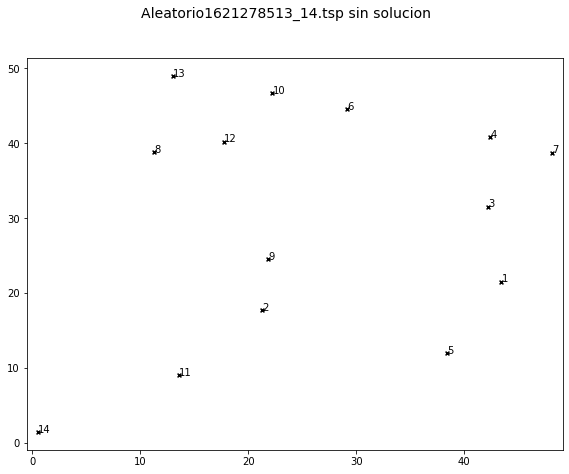

In [23]:
tsp = TSP()
tsp.obtener_random(14)
print(tsp)
tsp.draw()

Otra forma de pintar el escenario es con la ruta que hay actualmente marcada como solución, como aun no hemos aplicado ningún procedimiento resolutivo, se unen los puntos por orden de número.

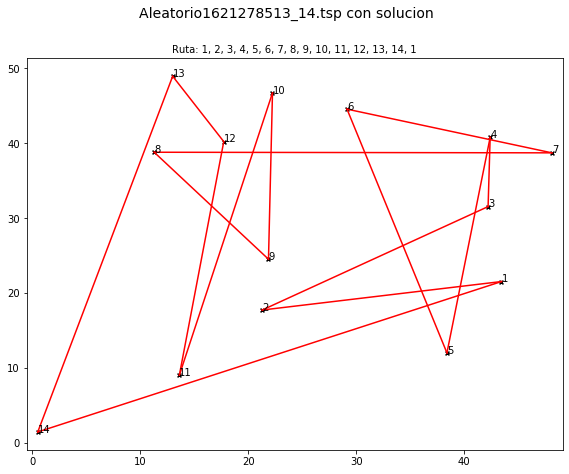

In [24]:
tsp.draw_with_solution()

Actualmente hemos cargado algunos métodos de utilidad y la clase TSP, donde se encuentran los métodos de solucion local y el método de solucion completa por backtracking, por ello podemos visualizar ya soluciones al problema de distintos algoritmos, veamos como ejemplo la solucion greedy al problema que tenemos:

Solución greedy generada: 186.83252478835522m


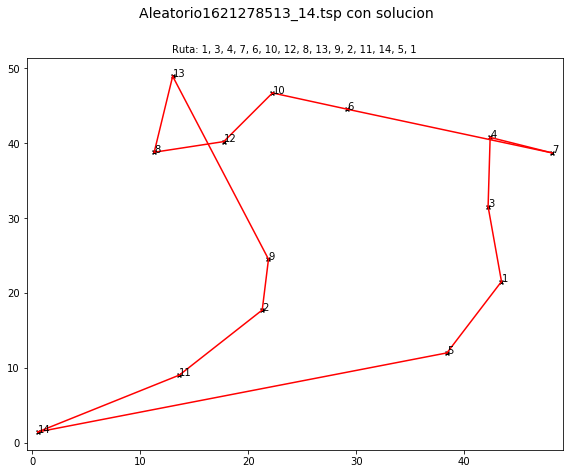

In [26]:
tsp.greedy_solve()
tsp.draw_with_solution()

También podemos aplicar la mejora 2-opt

Solucion 2-opt: 172.68328867654944 m


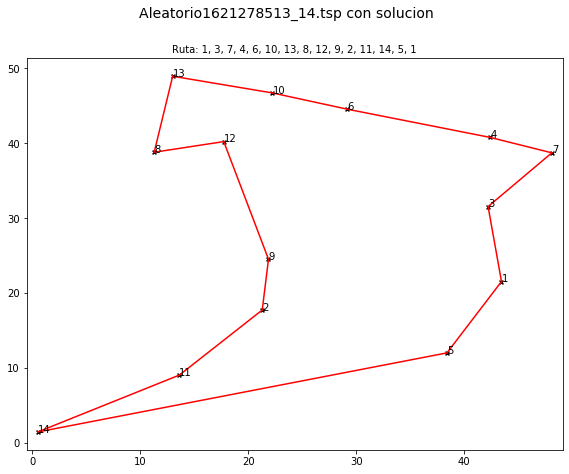

In [28]:
tsp.opt2()
tsp.draw_with_solution()

Por otro lado presentamos el algoritmo de solución inicial r-solve, el cual conecta los puntos en base al ángulo que forma el vector centro de las ciudades - ciudad con el eje de abscisas, Si entendemos el mapa como un plano 2d de coordenadas.

Solucion r: 200.6441971418816 m


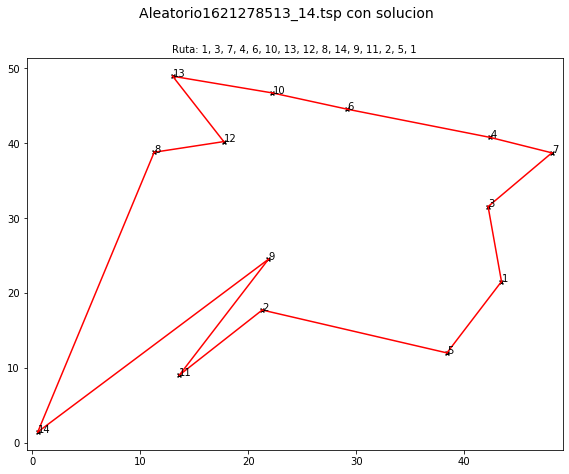

In [29]:
tsp.r_solve()
tsp.draw_with_solution()

El método r-solve funciona muy bien cuando lo combinamos con el procedimiento 2-opt

Solucion r: 200.6441971418816 m
Solucion 2-opt: 172.68328867654944 m


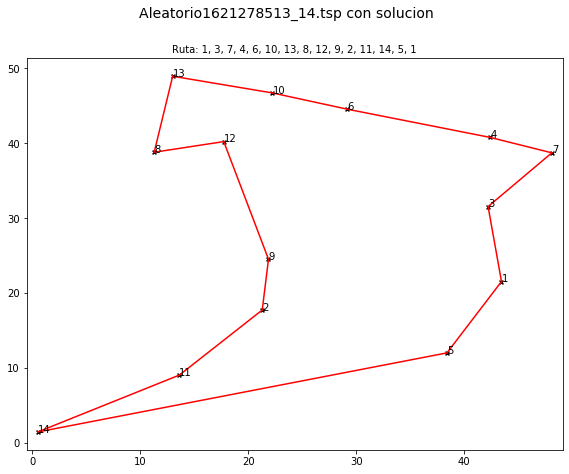

In [30]:
tsp.r_solve()
tsp.opt2()
tsp.draw_with_solution()

Vemos tambien un ejemplo de ejecucion del algoritmo completo de backtracking, para ello, dado que no está muy optimizado, vamos a generar un escenario más pequeño, de 6 ciudades y ejecutamos el método

59.69600011420675
[1, 6, 4, 5, 3, 2]
Solucion backtracking: 59.69600011420675 m


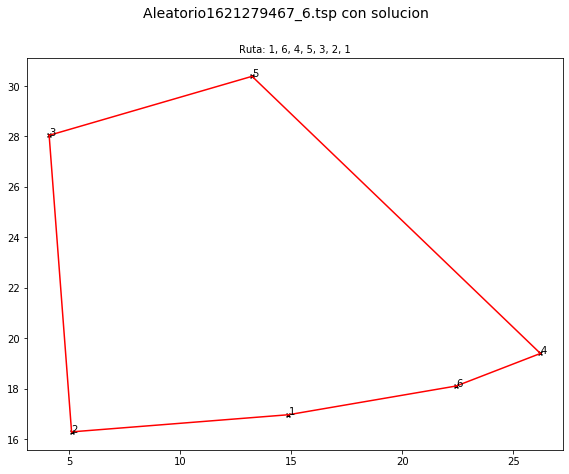

In [31]:
tsp.obtener_random(6)
tsp.backtracking_solve()
tsp.draw_with_solution()

El principal objeto de optimización y trabajo en este proyecto ha sido el método de ramificación y poda, además ha sido el método con el que hemos generado el banco de escenarios

In [13]:
import sys
!{sys.executable} -m pip install numba

     |████████████████████████████████| 3.4 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 33.9 MB/s eta 0:00:01


In [15]:
import time
from numba import njit
import numpy as np

#Adaptación realizada por Hugo Romero sobre el código de ng24_7 en geeksforgeeks
@njit
def copyToFinal(curr_path: np.array, final_path: np.array, N: int):
    for i in range(curr_path.size):
        final_path[i] = curr_path[i]
    final_path[N] = curr_path[0]

#Función g(TSP, list, int, int) implementada por Hugo Romero
#funcion heuristica, modificar cuando se desee para podar las ramas
#esta heuristica reduce unas 6 veces el tiempo de ejecucion
@njit
def g(graph: np.array, visited: np.array, level: int, adding_node: int): 
    bound = 0
    for i in range(graph.shape[0]):
        minim = np.inf
        second_minim = np.inf
        if not visited[i] and i != adding_node:
            for j in range(graph.shape[0]):
                if graph[i][j] > 0 and graph[i][j] < minim:
                    second_minim = minim
                    minim = graph[i][j]
                    
                elif graph[i][j] > 0 and graph[i][j] < second_minim:
                    second_minim = graph[i][j]
            bound = bound + (minim+second_minim)/2
    return bound

@njit
def g2(graph: np.array, visited: np.array, level: int, adding_node: int): 
    bound = 0
    for i in range(graph.shape[0]):
        minim = np.inf
        second_minim = np.inf
        if not visited[i] and i != adding_node:
            for j in range(graph.shape[0]):
                if graph[i][j] > 0 and graph[i][j] < minim and (not visited[j] or j==0 or j==level-1):
                    second_minim = minim
                    minim = graph[i][j]
                    
                elif graph[i][j] > 0 and graph[i][j] < second_minim:
                    second_minim = graph[i][j]
            if minim < np.inf and second_minim < np.inf:
                bound = bound + (minim+second_minim)/2
    return bound

#Adaptación realizada por Hugo Romero sobre el código de ng24_7 en geeksforgeeks

@njit
def TSPRec(graph: np.array, curr_weight: int,level: int, curr_path: np.array, visited: np.array, final_path: np.array, final_res: np.array):
    if level == graph.shape[0]:
        curr_res = curr_weight + graph[curr_path[level - 1]][curr_path[0]]
        if curr_res < final_res[0]:
            copyToFinal(curr_path, final_path, graph.shape[0])
            final_res[0] = curr_res
        return
  
    for i in range(graph.shape[0]):
        if (graph[curr_path[level-1]][i] != 0 and visited[i] == False):
            curr_weight = curr_weight + graph[curr_path[level - 1]][i]
            curr_bound = g2(graph, visited, level, i) #Aqui se hace la llamada a la heuristica
            if curr_bound + curr_weight < final_res[0]:
                curr_path[level] = i
                visited[i] = True
                TSPRec(graph, curr_weight, level + 1, curr_path, visited, final_path, final_res)
                
            curr_weight = curr_weight - graph[curr_path[level - 1]][i]
            visited = np.array([False] * len(visited))
            for j in range(level):
                if curr_path[j] != -1:
                    visited[curr_path[j]] = True
  
#Adaptación realizada por Hugo Romero sobre el código de ng24_7 en geeksforgeeks
#Ejecuta el algoritmo de ramificacion y poda (branch and bound) con heuristica
#por determinar (trabajo de cada grupo).
def branchAndBound(tsp):
    start = time.time()
    final_path = np.array([np.nan] * (tsp.dimension + 1))
    curr_path = np.array([-1] * (tsp.dimension + 1))
    visited = np.array([False] * tsp.dimension)
    visited[0] = True
    curr_path[0] = 0
    final_res = np.array([np.inf])
    TSPRec(tsp.graph, 0, 1, curr_path, visited, final_path, final_res)
    tsp.solution = list(map(lambda x: int(x+1), final_path.tolist()[:-1]))
    print(tsp.solution)
    end = time.time()
    print(f'Solución profundidad y poda generada: {tsp.compute_dist()}m. {end-start} segundos.')
    return(end-start)

De nuevo ampliemos el escenario y generemos nuestra primera solucion de ramificacion y poda

[1, 12, 4, 3, 5, 13, 11, 6, 9, 7, 8, 10, 14, 2]
Solución profundidad y poda generada: 146.65163388839153m. 0.07688784599304199 segundos.


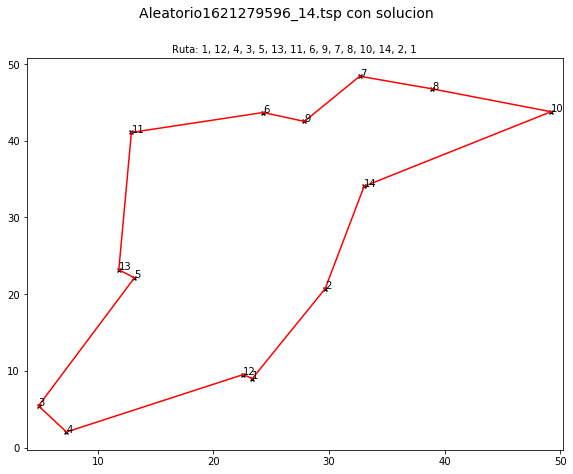

In [34]:
tsp.obtener_random(14)
branchAndBound(tsp)
tsp.draw_with_solution()

## Ya se ha visto como utilizar los principales métodos de la práctica, veamos por tanto aquellos procedimientos que se han aplicado para generar escenarios y realizar estudios.

El siguiente codigo no es para ejecutarlo aqui, pero es para representar como se obtuvo el archivo tiempos_branch_ejecucion.csv y como se han generado los escenarios de TSP_generados, carpeta donde hay almacenados escenarios y soluciones a esos escenarios.



# NO EJECUTAR O SE SOBREESCRIBIRA EL ARCHIVO DE TIEMPOS
from time import sleep
import pandas as pd
import time

if __name__ == '__main__':
    tsp = TSP() #Crear el objeto
    
    min_dim = 4
    max_dim = 21
    scenarios_per_dim = 20
    tiempos = {}
    
    
    for dim in range(min_dim, max_dim):
        tiempos[dim] = [None]*scenarios_per_dim
        for i in range(scenarios_per_dim):
            sleep(1)
            tsp.obtener_random(dim)
            time = branchAndBound(tsp)
            tiempos[dim][i] = time
            tsp.save_scenario()
            tsp.save_solucion()
            df = pd.DataFrame(tiempos)
            df.to_csv('tiempos_branch_ejecucion.csv', index = False)
            print(f'Generado {i+1}/{scenarios_per_dim} de {dim} ciudades')

Una vex producido y almacenado el archivo se hizo el estudio empirico relativo al branch and bound, para ello produjimos el siguiete snippet

              13         14         15         16         17         18  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.327973   1.717633   3.372622   3.628735   4.290365  14.334227   
std     0.426626   3.491181   3.722900   3.595960   5.274784  17.118942   
min     0.031953   0.075825   0.243379   0.120677   0.184506   1.203787   
25%     0.057248   0.219430   0.939731   1.394774   0.971408   2.341983   
50%     0.179036   0.429363   1.954756   2.118332   1.572410   7.926789   
75%     0.332862   1.017912   3.876627   4.250772   5.219797  20.147782   
max     1.749570  12.255520  12.957330  13.463539  17.667512  58.876584   

               19          20  
count   20.000000   20.000000  
mean    62.295339  125.164160  
std     85.767781  162.976104  
min      2.324948   15.446208  
25%      8.694658   26.920518  
50%     15.296393   43.897816  
75%     66.840900  103.771678  
max    286.748364  451.973815  


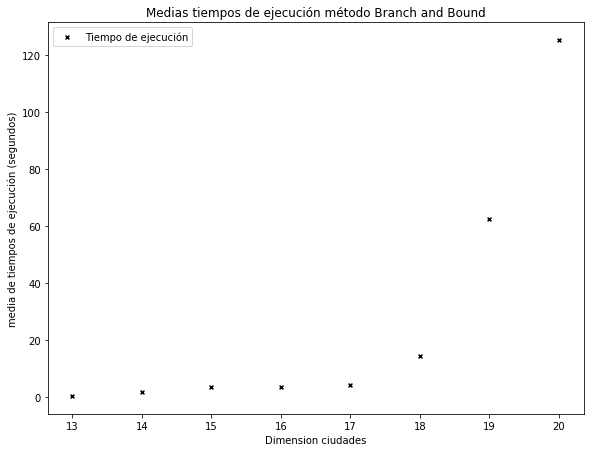

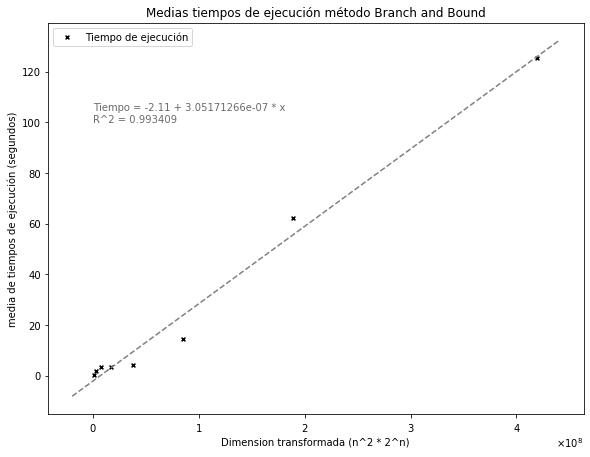

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def abline(x, y):
    """Plot a line from slope and intercept"""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    axes = plt.gca()
    
    x_vals = np.array(axes.get_xlim())
    # x_vals[0] = -intercept/slope
    y_vals = intercept + slope * x_vals
    
    plt.plot(x_vals, y_vals, '--', color= 'gray')
    axes.text(0, 100, f"Tiempo = {round(intercept, 3)} + {round(slope, 15)} * x\nR^2 = {round(r_value, 6)}", horizontalalignment='left', size='medium', color='dimgrey', weight='normal')
    
if __name__ == '__main__':
    df = pd.read_csv('tiempos_branch_ejecucion.csv')

    width = 9.6
    height = 7.2
    plt.figure(0, figsize=(width, height))
    df = df.iloc[:, 9:18]
    
    plt.scatter(list(map(int, df.columns)), df.mean().values,s=15, marker='x', c='black', label = 'Tiempo de ejecución')

    plt.legend()
    plt.xlabel('Dimension ciudades')
    plt.ylabel('media de tiempos de ejecución (segundos)')
    plt.title('Medias tiempos de ejecución método Branch and Bound')
    
    plt.figure(1, figsize=(width, height))
    plt.scatter(list(map(lambda x: x**2*2**x, list(map(int, df.columns)))), df.mean().values,s=15, marker='x', c='black', label = 'Tiempo de ejecución')
    
    
    plt.legend()
    plt.xlabel('Dimension transformada (n^2 * 2^n)')
    plt.ylabel('media de tiempos de ejecución (segundos)')
    plt.title('Medias tiempos de ejecución método Branch and Bound')
    
    a = df.describe()
    print(df.describe())
    abline(list(map(lambda x: x**2*2**x, list(map(int, df.columns)))), df.mean().values)
    plt.ticklabel_format(axis='x',style = "sci", useMathText=True)


Otro de los procedimientos que se ha tenido que hacer es el estudio de las soluciones por algoritmo de búsqueda local, este procedimiento se ha estudiado con el siguiente código:

Fichero ./TSP_generados/Aleatorio1621103220_4.tsp parseado con exito
Solucion desde archivo: 38.08510197480039 m
Solucion 2-opt: 44.04231060380394 m
Solución greedy generada: 38.08510197480039m
Solucion 2-opt: 38.08510197480039 m
Solucion r: 38.08510197480039 m
Solucion 2-opt: 38.08510197480039 m
Fichero ./TSP_generados/Aleatorio1621103111_4.tsp parseado con exito
Solucion desde archivo: 87.47396617251987 m
Solucion 2-opt: 87.47396617251987 m
Solución greedy generada: 94.9472875435147m
Solucion 2-opt: 94.9472875435147 m
Solucion r: 87.47396617251987 m
Solucion 2-opt: 87.47396617251987 m
Fichero ./TSP_generados/Aleatorio1621103004_4.tsp parseado con exito
Solucion desde archivo: 99.74055040361452 m
Solucion 2-opt: 104.01645137358743 m
Solución greedy generada: 99.74055040361452m
Solucion 2-opt: 99.74055040361452 m
Solucion r: 99.74055040361452 m
Solucion 2-opt: 99.74055040361452 m
Fichero ./TSP_generados/Aleatorio1621103120_4.tsp parseado con exito
Solucion desde archivo: 123.6498285766

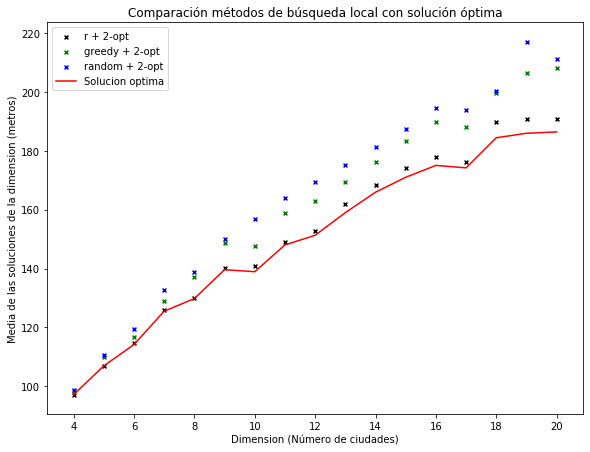

In [44]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import time


    
if __name__ == '__main__':
    d = {}
    tsp = TSP()
    
    x_dim = []
    opt_sum = []
    ropt_sum = []
    gopt_sum = []
    ranopt_sum = []
    
    porcentaje_acierto_ropt = []
    porcentaje_acierto_gopt = []
    porcentaje_acierto_ranopt = []
    
    for i in range(4, 21):
        files = glob.glob(f'./TSP_generados/Aleatorio*_{i}.tsp')
        x = []
        y = []
        y_ropt = [] #r+2opt
        y_gopt = [] #greedy+opt2
        y_ranopt = [] #random+opt2
        
        
        aciertos_ropt = 0
        aciertos_gopt = 0
        aciertos_ranopt = 0
        for index,file in enumerate(files):
            
            tsp.obtener_desde_archivo_tsp(file)
            tsp.aplicar_mejor_solucion_desde_archivo()
            x.append(index+1)
            y.append(tsp.compute_dist())
            best_sol = tsp.compute_dist()
            
            
            tsp.shuffle()
            tsp.opt2()
            y_ranopt.append(tsp.compute_dist())
            if tsp.compute_dist() == best_sol:
                aciertos_ranopt+=1
            
            tsp.greedy_solve()
            tsp.opt2()
            y_gopt.append(tsp.compute_dist())
            if tsp.compute_dist() == best_sol:
                aciertos_gopt+=1
                
            
            tsp.r_solve()
            tsp.opt2()
            y_ropt.append(tsp.compute_dist())
            if tsp.compute_dist() == best_sol:
                aciertos_ropt+=1
                
        
        porcentaje_acierto_ropt.append(round(aciertos_ropt/ len(files), 3)* 100)
        porcentaje_acierto_gopt.append(round(aciertos_gopt/len(files), 3)* 100)
        porcentaje_acierto_ranopt.append(round(aciertos_ranopt/len(files), 3)* 100)
        
        
        x_dim.append(i)
        opt_sum.append(np.mean(y))
        ropt_sum.append(np.mean(y_ropt))
        gopt_sum.append(np.mean(y_gopt))
        ranopt_sum.append(np.mean(y_ranopt))

    width = 9.6
    height = 7.2
    plt.figure(0, figsize=(width, height))
    plt.errorbar(x_dim, opt_sum,lolims=True, label = 'Solucion optima', color = 'red')
        
    plt.scatter(x_dim, ropt_sum, s=15, marker='x', c='black', label = 'r + 2-opt')
    plt.scatter(x_dim, gopt_sum, s=15, marker='x', c='green', label = 'greedy + 2-opt')
    plt.scatter(x_dim, ranopt_sum, s=15, marker='x', c='blue', label = 'random + 2-opt')
    plt.legend()
    plt.xlabel('Dimension (Número de ciudades)')
    plt.ylabel('Media de las soluciones de la dimension (metros)')
    plt.title('Comparación métodos de búsqueda local con solución óptima')
    
    ratios_ropt = [i/j for i,j in zip(ropt_sum, opt_sum)]
    ratios_gopt = [i/j for i,j in zip(gopt_sum, opt_sum)]
    ratios_ranopt = [i/j for i,j in zip(ranopt_sum, opt_sum)]
    
    print(f'\n\nAciertos random+2opt{porcentaje_acierto_ranopt}\nAciertos greedy+2opt{porcentaje_acierto_gopt}\nAciertos r-solve+2opt{porcentaje_acierto_ropt}')
    print(f'Ratios random+2opt{ratios_ranopt}\nRatios greedy+2opt{ratios_gopt}\nRatios r-solve+2opt{ratios_ropt}')

Por último para escoger la forma de programar la heuristica del algoritmo de ramificación y poda, realizamos un estudio de las distintas formas de implementarla. En nuestro caso realizamos 50 iteraciones, es decir, el valor de la varaiable repetitions era 50, dejamos puesto 5 para que se haga una idea de como se realizó el estudio pero no sea excesivo el tiempo de ejecución.

In [47]:
import numpy as np
from numba import njit

@njit
def min2_1_jit(arr):
    bound = 0
    for i in range(arr.shape[0]):
        minim = np.inf
        second_minim = np.inf
        for j in range(arr.shape[0]):
            if arr[i][j] > 0 and arr[i][j] < minim:
                second_minim = minim
                minim = arr[i][j]    
            elif arr[i][j] > 0 and arr[i][j] < second_minim:
                    second_minim = arr[i][j]
        bound = bound + (minim+second_minim)/2
    return bound

@njit
def min2_2_jit(arr):
    bound = 0
    for i in range(arr.shape[0]):
        A, B = np.partition(arr[i], 2)[1:3]
        bound = bound + (A+B)/2
        
    return bound


@njit
def min2_3_jit(arr):
    bound = 0
    for i in range(arr.shape[0]):
        bound = bound + np.mean(np.sort(arr[i])[1:3])
    return bound

def min2_1(arr):
    bound = 0
    for i in range(arr.shape[0]):
        minim = np.inf
        second_minim = np.inf
        for j in range(arr.shape[0]):
            if arr[i][j] > 0 and arr[i][j] < minim:
                second_minim = minim
                minim = arr[i][j]    
            elif arr[i][j] > 0 and arr[i][j] < second_minim:
                    second_minim = arr[i][j]
        bound = bound + (minim+second_minim)/2
    return bound


def min2_2(arr):
    bound = 0
    for i in range(arr.shape[0]):
        A, B = np.partition(arr[i], 2)[1:3]
        bound = bound + (A+B)/2
        
    return bound



def min2_3(arr):
    bound = 0
    for i in range(arr.shape[0]):
        bound = bound + np.mean(np.sort(arr[i])[1:3])
    return bound



if __name__ == '__main__':
    tsp = TSP()
    arr = tsp.obtener_random(1000)
    import time
    repetitions = 5
    total1 = []
    for i in range(repetitions):
        start = time.time()
        res = min2_1(tsp.graph)
        end = time.time()
        total1.append(end - start)
        print(f'{i}/{repetitions}')
    print(f'Media min21 : {np.mean(total1[1:])}')
    total2 = []
    for i in range(repetitions):
        start = time.time()
        res = min2_2(tsp.graph)
        end = time.time()
        total2.append(end - start)
    print(f'Media min22: {np.mean(total2[1:])}')
    total3 = []
    for i in range(repetitions):
        start = time.time()
        res = min2_3(tsp.graph)
        end = time.time()
        total3.append(end - start)
    print(f'Media min23: {np.mean(total3[1:])}')
    total4 = []
    for i in range(repetitions):
        start = time.time()
        res = min2_1_jit(tsp.graph)
        end = time.time()
        total4.append(end - start)
    print(f'Media min21jit: {np.mean(total4[1:])}')
    total5 = []
    for i in range(repetitions):
        start = time.time()
        res = min2_2_jit(tsp.graph)
        end = time.time()
        total5.append(end - start)
    print(f'Media min22jit: {np.mean(total5[1:])}')
    total6 = []
    for i in range(repetitions):
        start = time.time()
        res = min2_3_jit(tsp.graph)
        end = time.time()
        total6.append(end - start)
    print(f'Media min23jit: {np.mean(total6[1:])}')

0/5
1/5
2/5
3/5
4/5
Media min21 : 1.324533998966217
Media min22: 0.010859370231628418
Media min23: 0.060496985912323
Media min21jit: 0.002202630043029785
Media min22jit: 0.014145374298095703
Media min23jit: 0.059345781803131104


Este notebook recoge resumido todo el trabajo realizado, se ha creado para que sea más sencilla la visualizacion del procedimiento aplicado por el grupo y se entienda cual es el resultado final. Como es lógico no se recogen las distitas iteraciones por las que ha pasado el codigo ni los más de 50 commits del repositorio de desarrollo, que pueden servir como referencia de por cuantas etapas ha pasado el codigo.